In [1]:
ls

 Volume in drive C is OS
 Volume Serial Number is D816-28B0

 Directory of C:\Users\luigi\FlatironSchool\market_segmentation\Customer_segmentation

08/05/2020  11:05    <DIR>          .
08/05/2020  11:05    <DIR>          ..
03/05/2020  10:17    <DIR>          .ipynb_checkpoints
20/09/2019  22:35        45,580,638 data.csv
08/05/2020  11:05           243,023 Market segmentation.ipynb
30/04/2020  13:48                55 README.md
               3 File(s)     45,823,716 bytes
               3 Dir(s)   4,266,438,656 bytes free


In [36]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

In [3]:
# read the datafile
df_initial = pd.read_csv('data.csv',encoding="ISO-8859-1")
df_initial.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [4]:
print('Dataframe dimensions:', df_initial.shape)

Dataframe dimensions: (541909, 8)


In [5]:
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])

In [6]:
# gives some infos on columns types and number of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)
#__________________
# show first lines
display(df_initial[:5])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,float64,object
null values (nb),0,0,1454,0,0,0,135080,0
null values (%),0,0,0.268311,0,0,0,24.9267,0


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


  ∼ 25% of the entries are not assigned to a particular customer. With the data available, it is impossible to impute values for the user and these entries are thus useless for the current exercise. So I delete them from the dataframe:

In [7]:
df_initial.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Dataframe dimensions:', df_initial.shape)
#____________________________________________________________
# gives some infos on columns types and numer of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

Dataframe dimensions: (406829, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,float64,object
null values (nb),0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0


OK, therefore, by removing these entries we end up with a dataframe filled at 100% for all variables! Finally, I check for duplicate entries and delete them:

In [8]:
print('Duplicates: {}'.format(df_initial.duplicated().sum()))
df_initial.drop_duplicates(inplace = True)

Duplicates: 5225


###  Exploring the content of variables

This dataframe contains 8 variables that correspond to:

InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.

StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.

Description: Product (item) name. Nominal.

Quantity: The quantities of each product (item) per transaction. Numeric.

InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.

UnitPrice: Unit price. Numeric, Product price per unit in sterling.

CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.

Country: Country name. Nominal, the name of the country where each customer resides.

### Countries

In [9]:
temp = df_initial[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()
print('Nb. countries: {}'.format(len(countries) - 1))

Nb. countries: 36


and show the result on a chloropleth map:

In [10]:
data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Order nb.'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)
#_______________________
layout = dict(title='Number of orders per country',
geo = dict(showframe = True, projection={'type':'mercator'}))
#______________
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)


We see that the dataset is largely dominated by orders made from the UK.

### Customers and products

The dataframe contains  ∼ 400,000 entries. What are the number of users and products in these entries ?

In [11]:
pd.DataFrame([{'products': len(df_initial['StockCode'].value_counts()),    
               'transactions': len(df_initial['InvoiceNo'].value_counts()),
               'customers': len(df_initial['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3684,22190,4372


It can be seen that the data concern 4372 users and that they bought 3684 different products. The total number of transactions carried out is of the order of  ∼ 22'000.

Now I will determine the number of products purchased in every transaction:

In [12]:
temp = df_initial.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346.0,541431,1
1,12346.0,C541433,1
2,12347.0,537626,31
3,12347.0,542237,29
4,12347.0,549222,24
5,12347.0,556201,18
6,12347.0,562032,22
7,12347.0,573511,47
8,12347.0,581180,11
9,12348.0,539318,17


The first lines of this list shows several things worthy of interest:

- the existence of entries with the prefix C for the InvoiceNo variable: this indicates transactions that have been canceled
- the existence of users who only came once and only purchased one product (e.g. nº12346)
- the existence of frequent users that buy a large number of items at each order


###  Cancelling orders

First of all, I count the number of transactions corresponding to canceled orders:

In [13]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
display(nb_products_per_basket[:5])
#______________________________________________________________________________________________
n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12346.0,541431,1,0
1,12346.0,C541433,1,1
2,12347.0,537626,31,0
3,12347.0,542237,29,0
4,12347.0,549222,24,0


Number of orders canceled: 3654/22190 (16.47%) 


We note that the number of cancellations is quite large ( ∼ 16% of the total number of transactions). Now, let's look at the first lines of the dataframe:

In [14]:
display(df_initial.sort_values('CustomerID')[:5])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-08-02 08:48:00,4.25,12347.0,Iceland
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,2011-01-26 14:30:00,0.55,12347.0,Iceland
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347.0,Iceland


On these few lines, we see that when an order is canceled, we have another transactions in the dataframe, mostly identical except for the Quantity and InvoiceDate variables. I decide to check if this is true for all the entries. To do this, I decide to locate the entries that indicate a negative quantity and check if there is systematically an order indicating the same quantity (but positive), with the same description (CustomerID, Description and UnitPrice):

In [15]:
df_check = df_initial[df_initial['Quantity'] < 0][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]
for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
                & (df_initial['Description'] == col[2])].shape[0] == 0: 
        print(df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


We see that the initial hypothesis is not fulfilled because of the existence of a 'Discount' entry. I check again the hypothesis but this time discarding the 'Discount' entries:

In [16]:
df_check = df_initial[(df_initial['Quantity'] < 0) & (df_initial['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice']]

for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
                & (df_initial['Description'] == col[2])].shape[0] == 0: 
        print(index, df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

154 CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


## Insight on product categories
In the dataframe, products are uniquely identified through the StockCode variable. A shrort description of the products is given in the Description variable. In this section, I intend to use the content of this latter variable in order to group the products into different categories.

### Products Description
As a first step, I extract from the Description variable the information that will prove useful. To do this, I use the following function:

In [17]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Nb of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

This function takes as input the dataframe and analyzes the content of the Description column by performing the following operations:

extract the names (proper, common) appearing in the products description
for each name, I extract the root of the word and aggregate the set of names associated with this particular root
count the number of times each root appears in the dataframe
when several words are listed for the same root, I consider that the keyword associated with this root is the shortest name (this systematically selects the singular when there are singular/plural variants)
The first step of the analysis is to retrieve the list of products:

In [18]:
df_produits = pd.DataFrame(df_initial['Description'].unique()).rename(columns = {0:'Description'})

Once this list is created, I use the function I previously defined in order to analyze the description of the various products:

In [19]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_produits)

Nb of keywords in variable 'Description': 1484


The execution of this function returns three variables:

keywords: the list of extracted keywords
keywords_roots: a dictionary where the keys are the keywords roots and the values are the lists of words associated with those roots
count_keywords: dictionary listing the number of times every word is used
At this point, I convert the count_keywords dictionary into a list, to sort the keywords according to their occurences:

In [20]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

Using it, I create a representation of the most common keywords:

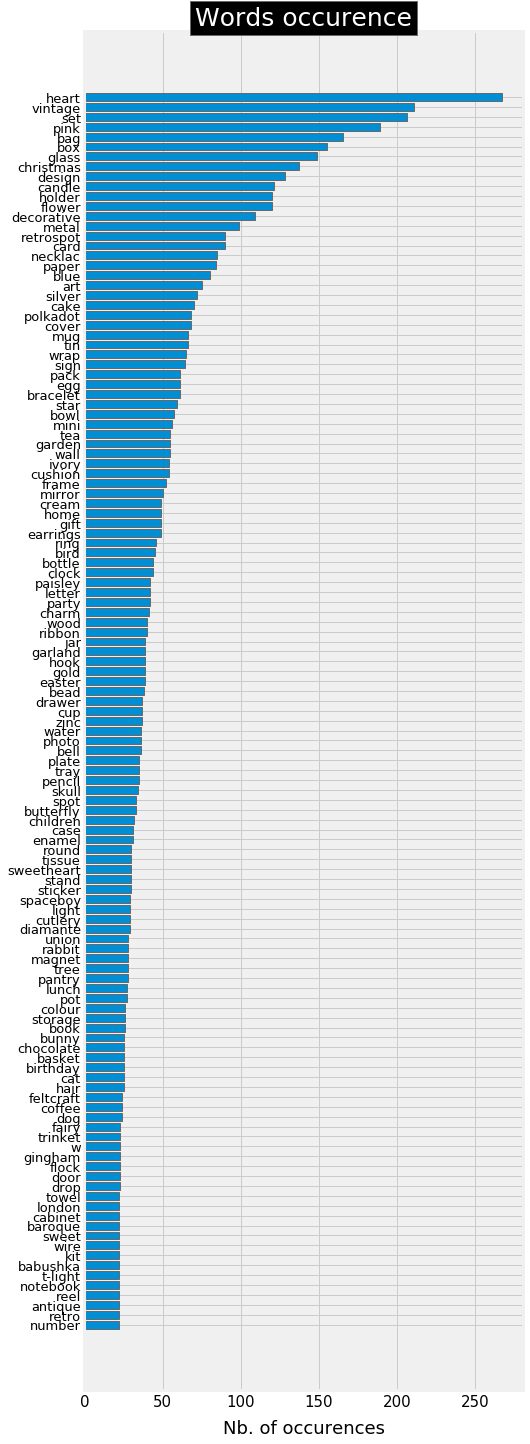

In [21]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)
#_______________________________
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
#_______________________________________________________________________________________
plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

### Defining product categories
The list that was obtained contains more than 1400 keywords and the most frequent ones appear in more than 200 products. However, while examinating the content of the list, I note that some names are useless. Others are do not carry information, like colors. Therefore, I discard these words from the analysis that follows and also, I decide to consider only the words that appear more than 13 times.

In [22]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
#______________________________________________________    
list_products.sort(key = lambda x:x[1], reverse = True)
print('Words kept:', len(list_products))

Words kept: 193


Now I will use these keywords to create groups of product. Firstly, I define the  X  matrix.

In [23]:
list_product = df_initial['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), list_product))

The  X  matrix indicates the words contained in the description of the products using the one-hot-encoding principle. In practice, I have found that introducing the price range results in more balanced groups in terms of element numbers. Hence, I add 6 extra columns to this matrix, where I indicate the price range of the products:

In [24]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(list_product):
    prix = df_initial[ df_initial['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

and to choose the appropriate ranges, I check the number of products in the different groups:

In [25]:
print("{:<8} {:<20} \n".format('gamme', 'nb. produits') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

gamme    nb. produits         
--------------------
0<.<1       965                 
1<.<2       1013                
2<.<3       674                 
3<.<5       611                 
5<.<10      476                 
.>10        157                 


### Creating clusters of products
In this section, I will group the products into different classes. In the case of matrices with binary encoding, the most suitable metric for the calculation of distances is the Hamming's metric. Note that the kmeans method of sklearn uses a Euclidean distance that can be used, but it is not to the best choice in the case of categorical variables. However, in order to use the Hamming's metric, we need to use the kmodes package which is not available on the current plateform. Hence, I use the kmeans method even if this is not the best choice.

In order to define (approximately) the number of clusters that best represents the data, I use the silhouette score:

In [26]:
matrix = X.as_matrix()
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.10062159302826501
For n_clusters = 4 The average silhouette_score is : 0.12601189170579502
For n_clusters = 5 The average silhouette_score is : 0.12541866611532027
For n_clusters = 6 The average silhouette_score is : 0.1471804114783156
For n_clusters = 7 The average silhouette_score is : 0.15014455858768327
For n_clusters = 8 The average silhouette_score is : 0.15093971296268985
For n_clusters = 9 The average silhouette_score is : 0.1367015502883102


In practice, the scores obtained above can be considered equivalent since, depending on the run, scores of  0.1±0.05  will be obtained for all clusters with n_clusters  >  3 (we obtain slightly lower scores for the first cluster). On the other hand, I found that beyond 5 clusters, some clusters contained very few elements. I therefore choose to separate the dataset into 5 clusters. In order to ensure a good classification at every run of the notebook, I iterate untill we obtain the best possible silhouette score, which is, in the present case, around 0.15:

In [27]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    
    #km = kmodes.KModes(n_clusters = n_clusters, init='Huang', n_init=2, verbose=0)
    #clusters = km.fit_predict(matrix)
    #silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.14709895533471118


### Characterizing the content of clusters

I check the number of elements in every class:

In [28]:
pd.Series(clusters).value_counts()

0    1013
3     965
1     674
2     633
4     611
dtype: int64

### a / Silhouette intra-cluster score

In order to have an insight on the quality of the classification, we can represent the silhouette scores of each element of the different clusters. This is the purpose of the next figure which is taken from the sklearn documentation:

In [29]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    #____________________________
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        #___________________________________________________________________________________
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        #____________________________________________________________________
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        #______________________________________
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  

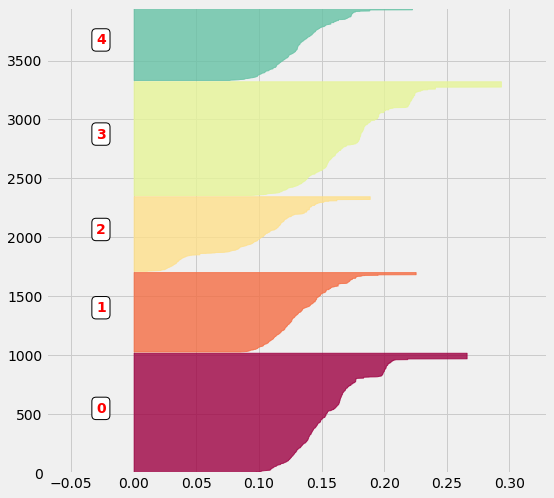

In [30]:
#____________________________________
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(matrix, clusters)
#__________________
# and do the graph
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

### b/ Word Cloud

Now we can have a look at the type of objects that each cluster represents. In order to obtain a global view of their contents, I determine which keywords are the most frequent in each of them

In [31]:
list_prod = pd.DataFrame(list_product)
list_words = [word for (word, occurence) in list_products]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    liste_cluster = list_prod.loc[clusters == i]
    for word in list_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        occurence[i][word] = sum(liste_cluster.loc[:, 0].str.contains(word.upper()))

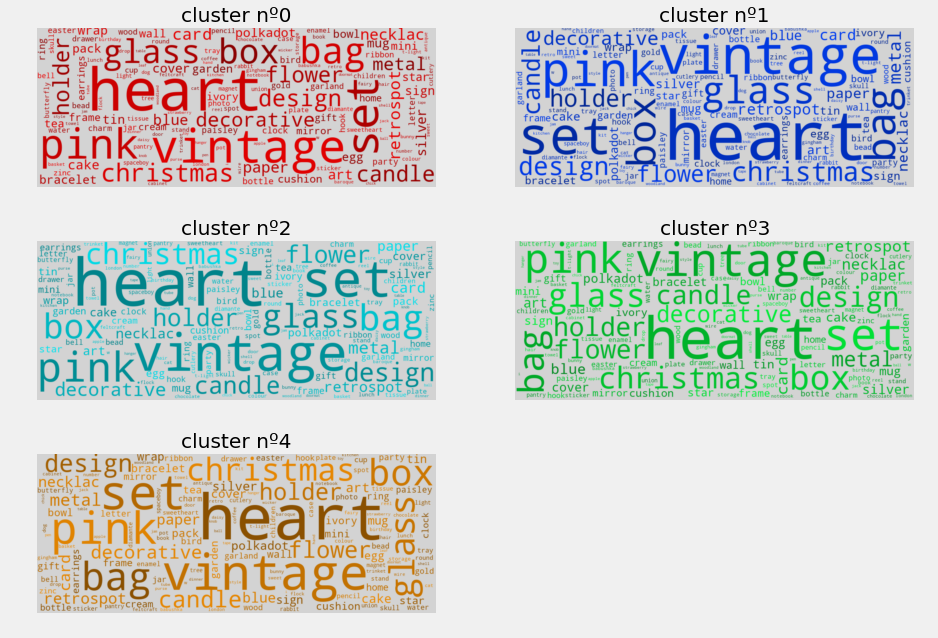

In [32]:
#________________________________________________________________________
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
#________________________________________________________________________
def make_wordcloud(list_prod, increment):
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = list_prod[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    #________________________________________________________
    wordcloud = WordCloud(width=1000,height=400, background_color='lightgrey', 
                          max_words=1628,relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster nº{}'.format(increment-1))
#________________________________________________________________________
fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurence[i]

    tone = color[i] # define the color of the words
    list_prod = []
    for key, value in list_cluster_occurences.items():
        list_prod.append([key, value])
    list_prod.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1)       

### c / Principal Component Analysis

In order to ensure that these clusters are truly distinct, I look at their composition. Given the large number of variables of the initial matrix, I first perform a PCA:

In [33]:
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

and then check for the amount of variance explained by each component:

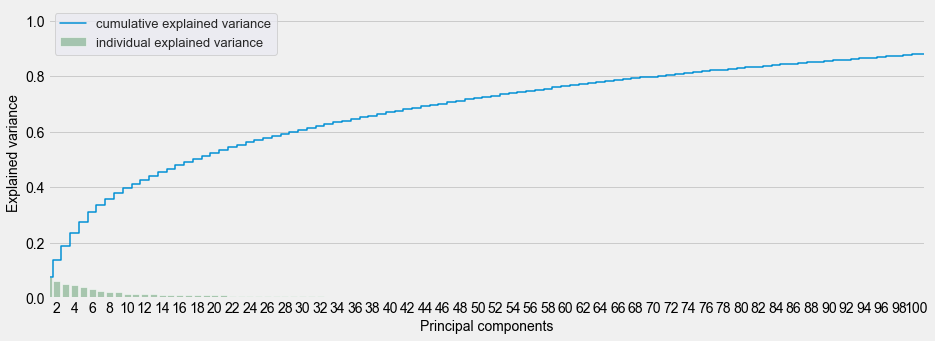

In [34]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 100)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);

We see that the number of components required to explain the data is extremely important: we need more than 100 components to explain 90% of the variance of the data. In practice, I decide to keep only a limited number of components since this decomposition is only performed to visualize the data:

In [35]:
pca = PCA(n_components=50)
matrix_9D = pca.fit_transform(matrix)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

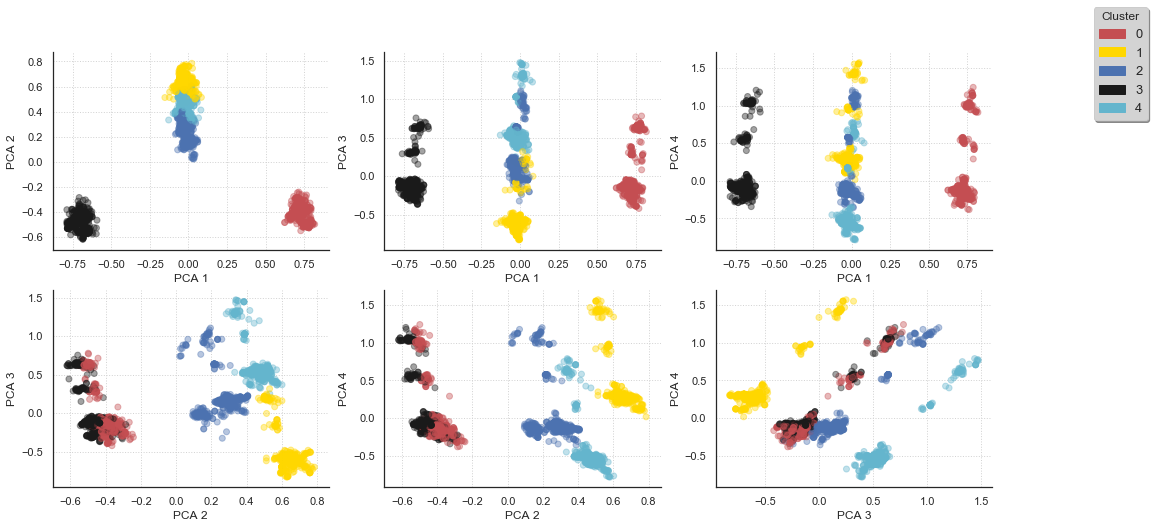

In [37]:
sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (15,8))
increment = 0
for ix in range(4):
    for iy in range(ix+1, 4):    
        increment += 1
        ax = fig.add_subplot(2,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.4) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 9: break
    if increment == 9: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(5):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.show()